In [ ]:
!nvidia-smi -L || echo "No GPU detected"

import os, random, math, time, json, pathlib, glob
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B2, preprocess_input
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

SEED = 123
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)


/bin/bash: line 1: nvidia-smi: command not found
No GPU detected
TF: 2.19.0
GPU: []


In [ ]:
# ===== Cell 1: Dataset paths =====
TRAIN_ROOT = "/content/Dataset/Training"
TEST_ROOT  = "/content/Dataset/Testing"

def list_classes(root):
    return sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])

assert os.path.isdir(TRAIN_ROOT), f"Missing: {TRAIN_ROOT}"
assert os.path.isdir(TEST_ROOT),  f"Missing: {TEST_ROOT}"

train_classes = list_classes(TRAIN_ROOT)
test_classes  = list_classes(TEST_ROOT)
assert set(train_classes) == set(test_classes), "Train/Test class sets differ — fix folder names."

CLASS_NAMES = train_classes
num_classes = len(CLASS_NAMES)
print("Classes:", CLASS_NAMES)

In [ ]:

IMG_SIZE   = (260, 260)
BATCH_SIZE = 32
EPOCHS     = 50
MODEL_OUT  = "brain_tumor_effv2b2_260.keras"

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.10),
    layers.RandomZoom(height_factor=(-0.12, 0.12), width_factor=(-0.12, 0.12)),
    layers.RandomContrast(0.12),
    layers.RandomTranslation(0.06, 0.06),
], name="augmentation")

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_ROOT,
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    image_size=IMG_SIZE,
    shuffle=True,
    batch_size=BATCH_SIZE,
    seed=SEED,
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_ROOT,
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    image_size=IMG_SIZE,
    shuffle=False,
    batch_size=BATCH_SIZE,
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(2048, seed=SEED).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)

def count_files(root, classes):
    counts = []
    for c in classes:
        d = os.path.join(root, c)
        cnt = sum(1 for p in Path(d).glob("*") if p.suffix.lower() in (".jpg",".jpeg",".png",".bmp",".tif",".tiff"))
        counts.append(cnt)
    return counts

train_counts = count_files(TRAIN_ROOT, CLASS_NAMES)
max_c = max(train_counts)
class_weight = {i: max_c / max(1, train_counts[i]) for i in range(num_classes)}
print("Train counts:", dict(zip(CLASS_NAMES, train_counts)))
print("Class weights:", class_weight)

Found 5938 files belonging to 5 classes.
Found 1546 files belonging to 5 classes.
Train counts: {'glioma': 1321, 'meningioma': 1339, 'not a brain images': 226, 'notumor': 1595, 'pituitary': 1457}
Class weights: {0: 1.2074186222558667, 1: 1.1911874533233757, 2: 7.057522123893805, 3: 1.0, 4: 1.0947151681537406}


In [ ]:
base = EfficientNetV2B2(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,),
    include_preprocessing=False,
)

inputs = layers.Input(shape=IMG_SIZE + (3,), name="input")
x = layers.Rescaling(1./255)(inputs)
x = data_augmentation(x)
x = preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.35)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs, name="brain_tumor_effv2b2_260")
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "brain_tumor_effv2b2_260"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 9, 9, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       721,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,495,395 (36.22 MB)

 Trainable params: 9,412,083 (35.90 MB)

 Non-trainable params: 83,312 (325.44 KB)

In [ ]:

ckpt_cb = callbacks.ModelCheckpoint(
    filepath="best_" + MODEL_OUT,
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)
early_cb = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=8,
    restore_best_weights=True,
    verbose=1
)
reduce_cb = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
for l in base.layers:
    l.trainable = False

history_frozen = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    class_weight=class_weight,
    callbacks=[ckpt_cb, early_cb, reduce_cb],
    verbose=1
)

Epoch 1/8
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6854 - loss: 1.2040
Epoch 1: val_accuracy improved from -inf to 0.81759, saving model to best_brain_tumor_effv2b2_260.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 152s 614ms/step - accuracy: 0.6857 - loss: 1.2024 - val_accuracy: 0.8176 - val_loss: 0.5126 - learning_rate: 0.0020
Epoch 2/8
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7833 - loss: 0.6588
Epoch 2: val_accuracy did not improve from 0.81759
186/186 ━━━━━━━━━━━━━━━━━━━━ 29s 154ms/step - accuracy: 0.7834 - loss: 0.6586 - val_accuracy: 0.8066 - val_loss: 0.5813 - learning_rate: 0.0020
Epoch 3/8
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8129 - loss: 0.5745
Epoch 3: val_accuracy did not improve from 0.81759
186/186 ━━━━━━━━━━━━━━━━━━━━ 28s 152ms/step - accuracy: 0.8129 - loss: 0.5745 - val_accuracy: 0.8131 - val_loss: 0.5291 - learning_rate: 0.0020
Epoch 4/8
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8161 - loss: 0.5667
Epoch 4: val_

In [ ]:
# ===== Cell 6: Phase 2 fine-tune =====
num_layers = len(base.layers)
unfreeze_from = int(num_layers * 0.4)
for i, l in enumerate(base.layers):
    l.trainable = (i >= unfreeze_from)

model.compile(
    optimizer=optimizers.Adam(learning_rate=3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=[ckpt_cb, early_cb, reduce_cb],
    verbose=1
)


Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8080 - loss: 0.7998
Epoch 1: val_accuracy improved from 0.86611 to 0.93402, saving model to best_brain_tumor_effv2b2_260.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 114s 360ms/step - accuracy: 0.8083 - loss: 0.7982 - val_accuracy: 0.9340 - val_loss: 0.1697 - learning_rate: 3.0000e-04
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9257 - loss: 0.2266
Epoch 2: val_accuracy improved from 0.93402 to 0.95408, saving model to best_brain_tumor_effv2b2_260.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 63s 334ms/step - accuracy: 0.9257 - loss: 0.2265 - val_accuracy: 0.9541 - val_loss: 0.1155 - learning_rate: 3.0000e-04
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9489 - loss: 0.1652
Epoch 3: val_accuracy improved from 0.95408 to 0.95796, saving model to best_brain_tumor_effv2b2_260.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 63s 334ms/step - accuracy: 0.9490 - loss: 0.1651 - val_accuracy: 0.9580 - val_loss: 0.118

In [ ]:
# ===== Cell 7: Save & evaluate =====
model.save(MODEL_OUT)

try:
    import h5py
    model.save("brain_tumor_effv2b2_260.h5")
except Exception as e:
    print("H5 save skipped:", e)

best_model = tf.keras.models.load_model("best_" + MODEL_OUT)

y_true = []
for _, yb in val_ds.unbatch().batch(4096):
    y_true.extend(yb.numpy().tolist())
y_true = np.array(y_true)

y_prob = best_model.predict(val_ds, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
plt.figure(figsize=(7.6,6.6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (counts)")
plt.colorbar()
ticks = np.arange(num_classes)
plt.xticks(ticks, CLASS_NAMES, rotation=45, ha='right')
plt.yticks(ticks, CLASS_NAMES)
plt.xlabel("Predicted"); plt.ylabel("Actual")

th = cm.max()/2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i,j]:d}",
                 ha="center", va="center",
                 color="white" if cm[i,j] > th else "black")
plt.tight_layout(); plt.savefig("confusion_matrix_counts.png", dpi=150)
plt.show()

print("Overall accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification report:\n",
      classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

def plot_hist(h, title):
    acc = h.history.get("accuracy", []);  val_acc = h.history.get("val_accuracy", [])
    loss = h.history.get("loss", []);     val_loss = h.history.get("val_loss", [])
    if not acc: return
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(acc, label="Train"); ax[0].plot(val_acc, label="Val"); ax[0].legend(); ax[0].set_title(f"{title} - Acc")
    ax[1].plot(loss, label="Train"); ax[1].plot(val_loss, label="Val"); ax[1].legend(); ax[1].set_title(f"{title} - Loss")
    plt.tight_layout(); plt.show()

plot_hist(history_frozen, "Phase 1 (Frozen)")
plot_hist(history_ft, "Phase 2 (Fine-tune)")


NameError: name 'model' is not defined

Classes: ['glioma', 'meningioma', 'not a brain images', 'notumor', 'pituitary']
Found 1546 files belonging to 5 classes.
✅ Model loaded successfully!
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step


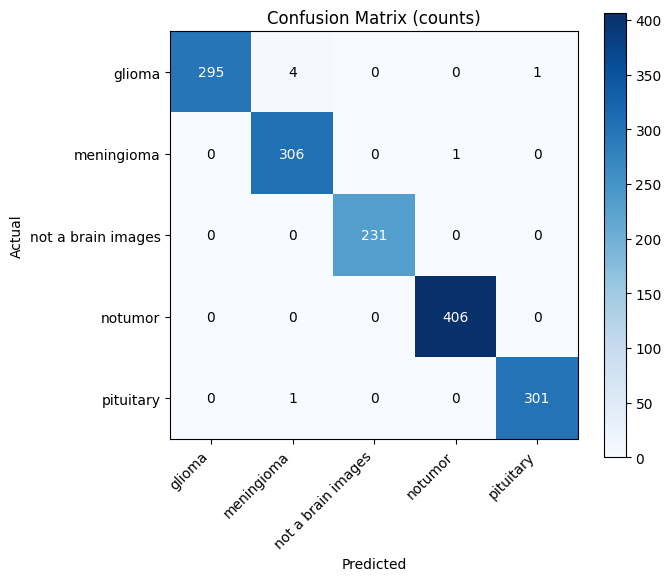


✅ Overall accuracy: 0.9954721862871928

Classification Report:
                     precision    recall  f1-score   support

            glioma     1.0000    0.9833    0.9916       300
        meningioma     0.9839    0.9967    0.9903       307
not a brain images     1.0000    1.0000    1.0000       231
           notumor     0.9975    1.0000    0.9988       406
         pituitary     0.9967    0.9967    0.9967       302

          accuracy                         0.9955      1546
         macro avg     0.9956    0.9954    0.9955      1546
      weighted avg     0.9955    0.9955    0.9955      1546



In [ ]:

import os, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

TRAIN_ROOT = "/content/Dataset/Training"
TEST_ROOT  = "/content/Dataset/Testing"
IMG_SIZE   = (260, 260)
BATCH_SIZE = 32

def list_classes(root):
    return sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])

CLASS_NAMES = list_classes(TRAIN_ROOT)
num_classes = len(CLASS_NAMES)
print("Classes:", CLASS_NAMES)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_ROOT,
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    image_size=IMG_SIZE,
    shuffle=False,
    batch_size=BATCH_SIZE,
).cache().prefetch(tf.data.AUTOTUNE)

MODEL_PATH = "best_brain_tumor_effv2b2_260.keras"
assert os.path.exists(MODEL_PATH), f"Model file not found: {MODEL_PATH}"
best_model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded successfully!")

y_true = np.concatenate([y.numpy() for _, y in val_ds.unbatch().batch(4096)])
y_prob = best_model.predict(val_ds, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (counts)")
plt.colorbar()
ticks = np.arange(num_classes)
plt.xticks(ticks, CLASS_NAMES, rotation=45, ha='right')
plt.yticks(ticks, CLASS_NAMES)
plt.xlabel("Predicted"); plt.ylabel("Actual")

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i,j]:d}",
                 ha="center", va="center",
                 color="white" if cm[i,j] > thresh else "black")
plt.tight_layout()
plt.show()

print("\n✅ Overall accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))


✅ Loaded Classes: ['glioma', 'meningioma', 'not a brain images', 'notumor', 'pituitary']
✅ Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


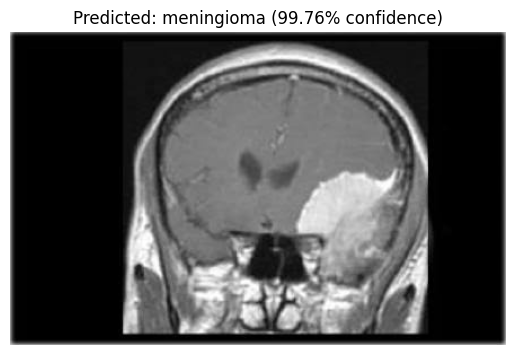


📄 ===== MRI SCAN REPORT =====

🧠 Predicted Tumor Type: MENINGIOMA
📊 Prediction Confidence: 99.76%
🩺 MRI File Path: /content/drive/MyDrive/Dataset/Testing/meningioma/Te-meTr_0000.jpg
📏 Estimated Tumor Size: 1.88 cm
🩸 Tumor Stage: Stage I (Early detection)

💊 Treatment Progress Table:
+-----------+-------------------------------+---------------------+
| Stage     | Treatment Method              | Expected Recovery   |
+===========+===============================+=====================+
| Stage I   | Surgical Removal              | 95% Recovery        |
+-----------+-------------------------------+---------------------+
| Stage II  | Radiation After Surgery       | 80% Recovery        |
+-----------+-------------------------------+---------------------+
| Stage III | Chemotherapy / Targeted Drugs | 60% Recovery        |
+-----------+-------------------------------+---------------------+

✅ Report generation complete.



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tabulate import tabulate

# ===== Paths =====
train_dir = '/content/drive/MyDrive/Dataset/Training'
save_model_path = '/content/drive/MyDrive/Colab Notebooks/best_brain_tumor_effv2b2_260.keras'
IMG_SIZE = (260, 260)

# ===== Load Class Names =====
CLASS_NAMES = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
VALID_CLASSES = {"glioma", "meningioma", "notumor", "pituitary"}
print("✅ Loaded Classes:", CLASS_NAMES)

# ===== Load Model =====
assert os.path.exists(save_model_path), f"❌ Model file not found: {save_model_path}"
try:
    model = tf.keras.models.load_model(save_model_path)
except Exception as e:
    print("⚠️ Standard load failed, retrying in safe mode...")
    model = tf.keras.models.load_model(save_model_path, safe_mode=False, compile=False)

print("✅ Model loaded successfully!")


# ===== MRI Report Function =====
def generate_report(pred_class, confidence, img_path):
    print("\n📄 ===== MRI SCAN REPORT =====\n")
    print(f"🧠 Predicted Tumor Type: {pred_class.upper()}")
    print(f"📊 Prediction Confidence: {confidence:.2f}%")
    print(f"🩺 MRI File Path: {img_path}")

    # Check if the image is a valid brain MRI
    if pred_class.lower() not in VALID_CLASSES:
        print("\n⚠️ Uploaded image is not recognized as a valid brain MRI.")
        print("🧾 Please upload a correct MRI image of the brain (glioma, meningioma, pituitary, or no tumor).")
        return

    # Mock tumor size (for demonstration)
    tumor_size_cm = round(random.uniform(1.0, 5.5), 2)
    print(f"📏 Estimated Tumor Size: {tumor_size_cm} cm")

    # Suggest stage based on size (dummy logic)
    if tumor_size_cm < 2:
        stage = "Stage I (Early detection)"
    elif tumor_size_cm < 4:
        stage = "Stage II (Localized growth)"
    else:
        stage = "Stage III (Requires urgent treatment)"
    print(f"🩸 Tumor Stage: {stage}")

    # ===== Treatment Progress Table (static sample) =====
    print("\n💊 Treatment Progress Table:")
    table_data = {
        "glioma": [
            ["Stage I", "Surgery or Radiation", "85% Recovery"],
            ["Stage II", "Surgery + Chemo", "70% Recovery"],
            ["Stage III", "Aggressive Therapy", "45% Recovery"],
        ],
        "meningioma": [
            ["Stage I", "Surgical Removal", "95% Recovery"],
            ["Stage II", "Radiation After Surgery", "80% Recovery"],
            ["Stage III", "Chemotherapy / Targeted Drugs", "60% Recovery"],
        ],
        "pituitary": [
            ["Stage I", "Observation / Hormone Therapy", "90% Recovery"],
            ["Stage II", "Surgical Removal", "80% Recovery"],
            ["Stage III", "Combined Therapy", "65% Recovery"],
        ],
        "notumor": [
            ["N/A", "No treatment required", "100% Normal"],
        ]
    }

    if pred_class.lower() in table_data:
        df = pd.DataFrame(table_data[pred_class.lower()],
                          columns=["Stage", "Treatment Method", "Expected Recovery"])
        print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))
    else:
        print("⚠️ No treatment data available for this class.")

    print("\n✅ Report generation complete.\n")


# ===== Prediction Function =====
def predict_image(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict
    preds = model.predict(img_array)
    pred_idx = np.argmax(preds, axis=1)[0]
    confidence = np.max(preds) * 100
    pred_class = CLASS_NAMES[pred_idx]

    # Display results visually
    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f"Predicted: {pred_class} ({confidence:.2f}% confidence)")
    plt.show()

    # Generate detailed report
    generate_report(pred_class, confidence, img_path)


# ===== Example Usage =====
img_path = "/content/drive/MyDrive/Dataset/Testing/meningioma/Te-meTr_0000.jpg"
predict_image(img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


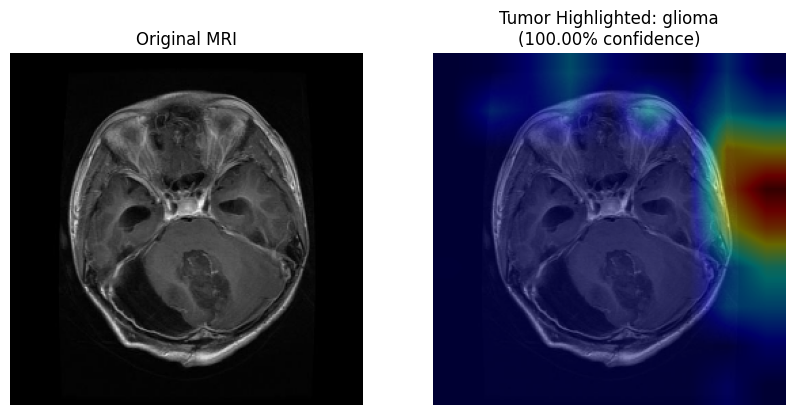

Predicted Class: glioma, Confidence: 100.00%


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import cv2


IMG_SIZE = (260, 260)
CLASS_NAMES = ['glioma', 'meningioma', 'not a brain images', 'notumor', 'pituitary']

def get_backbone(model):
    # Extract EfficientNet backbone
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model) and 'efficientnetv2' in layer.name:
            return layer
    raise ValueError("EfficientNet backbone not found!")

def make_gradcam_heatmap(img_array, backbone_model, class_idx):
    last_conv = backbone_model.get_layer('top_conv')
    grad_model = tf.keras.models.Model(
        [backbone_model.input],
        [last_conv.output, backbone_model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap,0)/tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, model):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array_exp = np.expand_dims(img_array, axis=0)
    img_array_exp = preprocess_input(img_array_exp)

    # Predict
    preds = model.predict(img_array_exp)
    pred_idx = np.argmax(preds)
    confidence = np.max(preds)*100
    pred_class = CLASS_NAMES[pred_idx]

    # Get backbone
    backbone = get_backbone(model)

    # Compute Grad-CAM
    heatmap = make_gradcam_heatmap(img_array_exp, backbone, pred_idx)
    heatmap_resized = cv2.resize(heatmap, (IMG_SIZE[1], IMG_SIZE[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Overlay on original resized image
    orig_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    overlay = cv2.addWeighted(orig_img, 0.6, heatmap_color, 0.4, 0)

    # Display
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
    plt.title("Original MRI")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Tumor Highlighted: {pred_class}\n({confidence:.2f}% confidence)")
    plt.axis('off')
    plt.show()

    print(f"Predicted Class: {pred_class}, Confidence: {confidence:.2f}%")



# Pick an image path manually
img_path = "/content/drive/MyDrive/Dataset/Testing/glioma/Te-glTr_0000.jpg"  # <-- change this

# Run Grad-CAM visualization
display_gradcam(img_path, model)



In [ ]:
!nvidia-smi -L || echo "No GPU detected"

import os, random, math, time, json, pathlib, glob
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B2, preprocess_input
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

SEED = 123
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)


# ===== Cell 1: Dataset paths =====
TRAIN_ROOT = "/content/Dataset/Training"
TEST_ROOT  = "/content/Dataset/Testing"

def list_classes(root):
    return sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])

assert os.path.isdir(TRAIN_ROOT), f"Missing: {TRAIN_ROOT}"
assert os.path.isdir(TEST_ROOT),  f"Missing: {TEST_ROOT}"

train_classes = list_classes(TRAIN_ROOT)
test_classes  = list_classes(TEST_ROOT)
assert set(train_classes) == set(test_classes), "Train/Test class sets differ — fix folder names."

CLASS_NAMES = train_classes
num_classes = len(CLASS_NAMES)
print("Classes:", CLASS_NAMES)



IMG_SIZE   = (260, 260)
BATCH_SIZE = 32
EPOCHS     = 50
MODEL_OUT  = "brain_tumor_effv2b2_260.keras"

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.10),
    layers.RandomZoom(height_factor=(-0.12, 0.12), width_factor=(-0.12, 0.12)),
    layers.RandomContrast(0.12),
    layers.RandomTranslation(0.06, 0.06),
], name="augmentation")

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_ROOT,
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    image_size=IMG_SIZE,
    shuffle=True,
    batch_size=BATCH_SIZE,
    seed=SEED,
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_ROOT,
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    image_size=IMG_SIZE,
    shuffle=False,
    batch_size=BATCH_SIZE,
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(2048, seed=SEED).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)

def count_files(root, classes):
    counts = []
    for c in classes:
        d = os.path.join(root, c)
        cnt = sum(1 for p in Path(d).glob("*") if p.suffix.lower() in (".jpg",".jpeg",".png",".bmp",".tif",".tiff"))
        counts.append(cnt)
    return counts

train_counts = count_files(TRAIN_ROOT, CLASS_NAMES)
max_c = max(train_counts)
class_weight = {i: max_c / max(1, train_counts[i]) for i in range(num_classes)}
print("Train counts:", dict(zip(CLASS_NAMES, train_counts)))
print("Class weights:", class_weight)

base = EfficientNetV2B2(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,),
    include_preprocessing=False,
)

inputs = layers.Input(shape=IMG_SIZE + (3,), name="input")
x = layers.Rescaling(1./255)(inputs)
x = data_augmentation(x)
x = preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.35)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs, name="brain_tumor_effv2b2_260")
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


ckpt_cb = callbacks.ModelCheckpoint(
    filepath="best_" + MODEL_OUT,
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)
early_cb = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=8,
    restore_best_weights=True,
    verbose=1
)
reduce_cb = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

for l in base.layers:
    l.trainable = False

history_frozen = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    class_weight=class_weight,
    callbacks=[ckpt_cb, early_cb, reduce_cb],
    verbose=1
)

# ===== Cell 6: Phase 2 fine-tune =====
num_layers = len(base.layers)
unfreeze_from = int(num_layers * 0.4)
for i, l in enumerate(base.layers):
    l.trainable = (i >= unfreeze_from)

model.compile(
    optimizer=optimizers.Adam(learning_rate=3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=[ckpt_cb, early_cb, reduce_cb],
    verbose=1
)


import os, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

TRAIN_ROOT = "/content/Dataset/Training"
TEST_ROOT  = "/content/Dataset/Testing"
IMG_SIZE   = (260, 260)
BATCH_SIZE = 32

def list_classes(root):
    return sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])

CLASS_NAMES = list_classes(TRAIN_ROOT)
num_classes = len(CLASS_NAMES)
print("Classes:", CLASS_NAMES)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_ROOT,
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    image_size=IMG_SIZE,
    shuffle=False,
    batch_size=BATCH_SIZE,
).cache().prefetch(tf.data.AUTOTUNE)

MODEL_PATH = "best_brain_tumor_effv2b2_260.keras"
assert os.path.exists(MODEL_PATH), f"Model file not found: {MODEL_PATH}"
best_model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded successfully!")

y_true = np.concatenate([y.numpy() for _, y in val_ds.unbatch().batch(4096)])
y_prob = best_model.predict(val_ds, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (counts)")
plt.colorbar()
ticks = np.arange(num_classes)
plt.xticks(ticks, CLASS_NAMES, rotation=45, ha='right')
plt.yticks(ticks, CLASS_NAMES)
plt.xlabel("Predicted"); plt.ylabel("Actual")

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i,j]:d}",
                 ha="center", va="center",
                 color="white" if cm[i,j] > thresh else "black")
plt.tight_layout()
plt.show()

print("\n✅ Overall accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))


✅ Model loaded: brain_tumor_effv2b2_260
✅ Nested base model found: efficientnetv2-b2
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted class index: 1 prob: 0.49701127
✅ Last conv layer inside EfficientNet base: top_conv
✅ Grad-CAM++ generated successfully


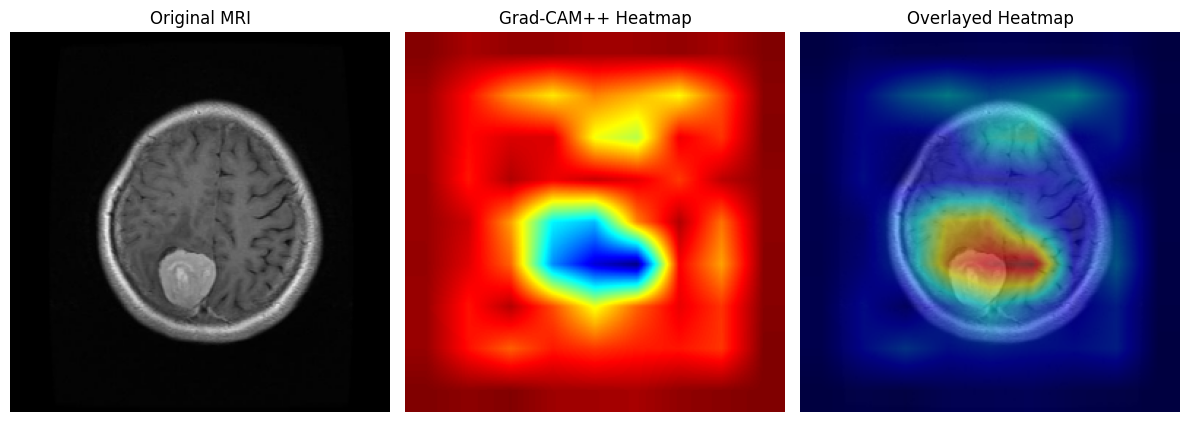

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# ---------- Settings ----------
model_path = "/content/drive/MyDrive/Colab Notebooks/best_brain_tumor_effv2b2_260.keras"
img_path   = "/content/drive/MyDrive/Dataset/Testing/meningioma/Te-me_0135.jpg"
IMG_SIZE = (260, 260)

# ---------- Load model ----------
best_model = load_model(model_path)
print("✅ Model loaded:", best_model.name)

# ---------- Extract the base EfficientNet model ----------
base_model = best_model.get_layer("efficientnetv2-b2")
print("✅ Nested base model found:", base_model.name)

# ---------- Load + preprocess image ----------
pil = image.load_img(img_path, target_size=IMG_SIZE)
orig_bgr = cv2.imread(img_path)
orig_bgr = cv2.resize(orig_bgr, (IMG_SIZE[1], IMG_SIZE[0]))

x = image.img_to_array(pil)
x = np.expand_dims(x, 0)
x = x / 255.0
x = tf.keras.applications.efficientnet_v2.preprocess_input(x)

# ---------- Predict ----------
pred = best_model.predict(x)
pred_class = int(np.argmax(pred[0]))
print("Predicted class index:", pred_class, "prob:", pred[0, pred_class])

# ---------- Get last conv layer ----------
last_conv = None
for layer in reversed(base_model.layers):
    if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
        last_conv = layer
        break
if last_conv is None:
    raise ValueError("❌ No conv layer found in EfficientNet base")
print("✅ Last conv layer inside EfficientNet base:", last_conv.name)

# ---------- Build Grad-CAM model ----------
grad_model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=[last_conv.output, base_model.output]
)

# ---------- Grad-CAM++ Implementation ----------
def gradcam_plus_plus(grad_model, img_tensor, class_idx):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                conv_output, predictions = grad_model(img_tensor)
                class_output = predictions[:, class_idx]
            grads = tape3.gradient(class_output, conv_output)
        grads2 = tape2.gradient(grads, conv_output)
    grads3 = tape1.gradient(grads2, conv_output)

    conv_output = conv_output[0]
    grads = grads[0]
    grads2 = grads2[0]
    grads3 = grads3[0]

    numerator = grads2
    denominator = 2.0 * grads2 + grads3 * conv_output
    denominator = tf.where(denominator != 0.0, denominator, tf.ones_like(denominator))
    alpha = numerator / denominator
    alpha = tf.nn.relu(alpha)

    weights = tf.reduce_sum(alpha * tf.nn.relu(grads), axis=(0, 1))
    heatmap = tf.reduce_sum(tf.nn.relu(conv_output) * weights, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)

    return heatmap  # <-- no .numpy()


# ---------- Generate Grad-CAM++ heatmap ----------
img_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
heatmap = gradcam_plus_plus(grad_model, img_tensor, pred_class)
print("✅ Grad-CAM++ generated successfully")

# ---------- Overlay ----------
def overlay_on_image(orig_bgr_uint8, heatmap, alpha=0.5):
    hmap = cv2.resize(heatmap, (orig_bgr_uint8.shape[1], orig_bgr_uint8.shape[0]))
    hmap = np.uint8(255 * hmap)
    hmap_color = cv2.applyColorMap(hmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(orig_bgr_uint8, 1 - alpha, hmap_color, alpha, 0)
    return hmap_color, overlay

hmap_color, overlay = overlay_on_image(orig_bgr, heatmap)

plt.figure(figsize=(12,6))
plt.subplot(1,3,1); plt.title("Original MRI"); plt.imshow(cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.subplot(1,3,2); plt.title("Grad-CAM++ Heatmap"); plt.imshow(hmap_color); plt.axis("off")
plt.subplot(1,3,3); plt.title("Overlayed Heatmap"); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.tight_layout()
plt.show()


✅ Model loaded: brain_tumor_effv2b2_260
✅ Nested base model found: efficientnetv2-b2
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Predicted class index: 1 prob: 0.49796513
✅ Last conv layer inside EfficientNet base: top_conv
✅ Grad-CAM++ with TTA generated successfully


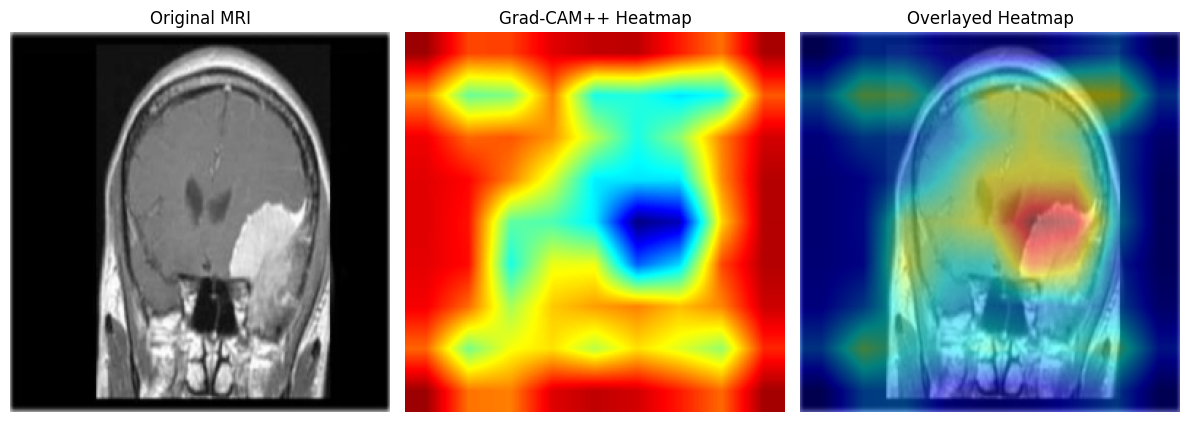

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# ---------- Settings ----------
model_path = "/content/drive/MyDrive/Colab Notebooks/best_brain_tumor_effv2b2_260.keras"
img_path   = "/content/drive/MyDrive/Dataset/Testing/meningioma/Te-meTr_0000.jpg"
IMG_SIZE = (260, 260)

# ---------- Load model ----------
best_model = load_model(model_path)
print("✅ Model loaded:", best_model.name)

# ---------- Extract the base EfficientNet model ----------
base_model = best_model.get_layer("efficientnetv2-b2")
print("✅ Nested base model found:", base_model.name)

# ---------- Load + preprocess image ----------
pil = image.load_img(img_path, target_size=IMG_SIZE)
orig_bgr = cv2.imread(img_path)
orig_bgr = cv2.resize(orig_bgr, (IMG_SIZE[1], IMG_SIZE[0]))

x = image.img_to_array(pil)
x = np.expand_dims(x, 0)
x = x / 255.0
x = tf.keras.applications.efficientnet_v2.preprocess_input(x)

# ---------- Predict ----------
pred = best_model.predict(x)
pred_class = int(np.argmax(pred[0]))
print("Predicted class index:", pred_class, "prob:", pred[0, pred_class])

# ---------- Get last conv layer ----------
last_conv = None
for layer in reversed(base_model.layers):
    if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
        last_conv = layer
        break
if last_conv is None:
    raise ValueError("❌ No conv layer found in EfficientNet base")
print("✅ Last conv layer inside EfficientNet base:", last_conv.name)

# ---------- Build Grad-CAM model ----------
grad_model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=[last_conv.output, base_model.output]
)

# ---------- Grad-CAM++ Implementation ----------
def gradcam_plus_plus(grad_model, img_tensor, class_idx):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                conv_output, predictions = grad_model(img_tensor)
                class_output = predictions[:, class_idx]
            grads = tape3.gradient(class_output, conv_output)
        grads2 = tape2.gradient(grads, conv_output)
    grads3 = tape1.gradient(grads2, conv_output)

    conv_output = conv_output[0]
    grads = grads[0]
    grads2 = grads2[0]
    grads3 = grads3[0]

    numerator = grads2
    denominator = 2.0 * grads2 + grads3 * conv_output
    denominator = tf.where(denominator != 0.0, denominator, tf.ones_like(denominator))
    alpha = numerator / denominator
    alpha = tf.nn.relu(alpha)

    weights = tf.reduce_sum(alpha * tf.nn.relu(grads), axis=(0, 1))
    heatmap = tf.reduce_sum(tf.nn.relu(conv_output) * weights, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)
    return heatmap  # return numpy array directly

# ---------- Test-Time Augmentation for robust Grad-CAM ----------
def get_tta_heatmap(model, grad_model, img_tensor, pred_class, angles=[0, 90, 180, 270], flip=True):
    heatmaps = []
    for angle in angles:
        # Rotate image
        img_rot = tf.image.rot90(img_tensor, k=angle // 90)
        heatmap = gradcam_plus_plus(grad_model, img_rot, pred_class)
        # Rotate heatmap back
        heatmap = np.rot90(heatmap, k=(4 - angle // 90))
        heatmaps.append(heatmap)
        if flip:
            # Horizontal flip
            img_flip = tf.image.flip_left_right(img_rot)
            heatmap_flip = gradcam_plus_plus(grad_model, img_flip, pred_class)
            heatmap_flip = np.fliplr(np.rot90(heatmap_flip, k=(4 - angle // 90)))
            heatmaps.append(heatmap_flip)
    # Average all heatmaps
    heatmap_avg = np.mean(np.stack(heatmaps), axis=0)
    heatmap_avg = np.maximum(heatmap_avg, 0)
    heatmap_avg /= (np.max(heatmap_avg) + 1e-8)
    return heatmap_avg

# ---------- Generate heatmap with TTA ----------
img_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
heatmap = get_tta_heatmap(best_model, grad_model, img_tensor, pred_class)
print("✅ Grad-CAM++ with TTA generated successfully")

# ---------- Overlay ----------
def overlay_on_image(orig_bgr_uint8, heatmap, alpha=0.5):
    hmap = cv2.resize(heatmap, (orig_bgr_uint8.shape[1], orig_bgr_uint8.shape[0]))
    hmap = np.uint8(255 * hmap)
    hmap_color = cv2.applyColorMap(hmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(orig_bgr_uint8, 1 - alpha, hmap_color, alpha, 0)
    return hmap_color, overlay

hmap_color, overlay = overlay_on_image(orig_bgr, heatmap)

# ---------- Display ----------
plt.figure(figsize=(12,6))
plt.subplot(1,3,1); plt.title("Original MRI"); plt.imshow(cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.subplot(1,3,2); plt.title("Grad-CAM++ Heatmap"); plt.imshow(hmap_color); plt.axis("off")
plt.subplot(1,3,3); plt.title("Overlayed Heatmap"); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.tight_layout()
plt.show()


✅ Loaded Classes from train dir: ['glioma', 'meningioma', 'not a brain images', 'notumor', 'pituitary']
✅ Model loaded (standard).
✅ Found nested EfficientNet base as layer: efficientnetv2-b2
✅ Found last conv layer inside base: top_conv
⚠️ Grad model construction via replay failed: too many positional arguments
✅ Grad model constructed (fallback using base_model.io).
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
✅ Prediction: glioma (100.00%)
✅ Grad-CAM++ heatmap produced (TTA).
✅ Overlay saved to: /content/drive/MyDrive/Dataset/Testing/glioma/Te-glTr_0000_gradcam_overlay.jpg
📄 ===== MRI SCAN REPORT =====
🧠 Predicted Tumor Type: GLIOMA
📊 Prediction Confidence: 100.00%
🩺 MRI File Path: /content/drive/MyDrive/Dataset/Testing/glioma/Te-glTr_0000.jpg
🔎 Image recognized as brain MRI? : YES

📏 Estimated Tumor Size (approx): 14.00 cm
   - Bounding box (pixels): xmin=0 xmax=8 ymin=0 ymax=8
   - Coverage of image (bbox area): 100.000%
   - Conversion assumption: image width ≈ 14.0 cm → pixel_to_cm ≈ 1.5

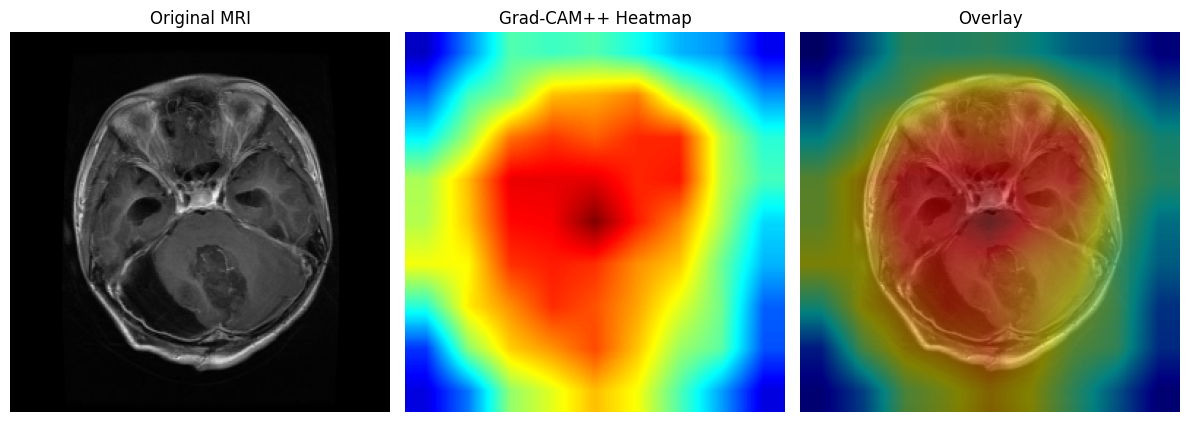

Returned result keys: ['predicted_class', 'confidence_pct', 'is_valid_brain_image', 'tumor_estimation', 'overlay_saved_path', 'report_text']


In [ ]:
# Combined MRI prediction + Grad-CAM++ + Report generator
# Requirements:
# tensorflow, numpy, matplotlib, opencv-python, pandas, tabulate

import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing import image
from tabulate import tabulate

# ---------- User settings ----------
TRAIN_DIR = '/content/drive/MyDrive/Dataset/Training'
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/best_brain_tumor_effv2b2_260.keras'
IMG_SIZE = (260, 260)
VALID_CLASSES = {"glioma", "meningioma", "notumor", "pituitary"}
ASSUMED_BRAIN_WIDTH_CM = 14.0
GRADCAM_THRESHOLD = 0.4
TTA_ANGLES = [0, 90, 180, 270]
TTA_FLIP = True

# ---------- Helper: load class names ----------
def load_class_names(train_dir):
    if not os.path.isdir(train_dir):
        print(f"⚠️ Train directory not found: {train_dir}. Class order must match model training order.")
        return None
    classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
    print("✅ Loaded Classes from train dir:", classes)
    return classes

# ---------- Load Keras model safely ----------
def safe_load_model(model_path):
    assert os.path.exists(model_path), f"Model file not found: {model_path}"
    try:
        model = tf.keras.models.load_model(model_path)
        print("✅ Model loaded (standard).")
    except Exception as e:
        print("⚠️ Standard load failed:", e)
        try:
            model = tf.keras.models.load_model(model_path, safe_mode=False, compile=False)
            print("✅ Model loaded (safe_mode=False, compile=False).")
        except Exception as e2:
            raise RuntimeError(f"Failed to load model: {e2}")
    return model

# ---------- Find EfficientNet base ----------
def find_effnet_base(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model) and 'efficientnet' in layer.name.lower():
            print("✅ Found nested EfficientNet base as layer:", layer.name)
            return layer
    for layer in reversed(model.layers):
        if 'efficientnet' in layer.name.lower():
            print("✅ Found EfficientNet by name in layers:", layer.name)
            return layer if isinstance(layer, tf.keras.Model) else model
    print("⚠️ EfficientNet base not found; returning full model.")
    return model

# ---------- Find last conv layer ----------
def find_last_conv_layer_in_modelbase(model_base):
    # Prefer explicit 'top_conv' then fallback to last Conv2D / DepthwiseConv2D
    for sub in model_base.layers:
        if 'top_conv' in sub.name:
            return sub
    for layer in reversed(model_base.layers):
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
            return layer
    # fallback by name heuristics
    for layer in reversed(model_base.layers):
        if 'conv' in layer.name or 'block' in layer.name:
            return layer
    raise ValueError("❌ No convolution layer found inside base model for Grad-CAM.")

# ---------- Grad-CAM++ ----------
def gradcam_plus_plus(grad_model, img_tensor, class_idx):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                conv_outs, preds = grad_model(img_tensor)
                loss = preds[:, class_idx]
            grads = tape3.gradient(loss, conv_outs)
        grads2 = tape2.gradient(grads, conv_outs)
    grads3 = tape1.gradient(grads2, conv_outs)

    conv_outs = conv_outs[0].numpy()
    grads = grads[0].numpy()
    grads2 = grads2[0].numpy()
    grads3 = grads3[0].numpy()

    numerator = grads2
    denominator = 2.0 * grads2 + grads3 * conv_outs
    denominator = np.where(denominator != 0.0, denominator, np.ones_like(denominator))
    alpha = np.maximum(numerator / denominator, 0.0)
    weights = np.sum(alpha * np.maximum(grads, 0.0), axis=(0, 1))
    heatmap = np.sum(np.maximum(conv_outs, 0.0) * weights[None, None, :], axis=-1)
    heatmap = np.maximum(heatmap, 0)
    return heatmap / (np.max(heatmap) + 1e-8)

def get_tta_heatmap(model, grad_model, img_tensor, pred_class, angles=TTA_ANGLES, flip=TTA_FLIP):
    heatmaps = []
    for angle in angles:
        k = (angle // 90) % 4
        img_rot = tf.image.rot90(img_tensor, k=k)
        hm = gradcam_plus_plus(grad_model, img_rot, pred_class)
        hm = np.rot90(hm, k=(4 - k))
        heatmaps.append(hm)
        if flip:
            img_flip = tf.image.flip_left_right(img_rot)
            hm_flip = gradcam_plus_plus(grad_model, img_flip, pred_class)
            hm_flip = np.fliplr(np.rot90(hm_flip, k=(4 - k)))
            heatmaps.append(hm_flip)
    heatmap_avg = np.mean(np.stack(heatmaps, axis=0), axis=0)
    heatmap_avg = np.maximum(heatmap_avg, 0)
    return heatmap_avg / (np.max(heatmap_avg) + 1e-8)

# ---------- Overlay ----------
def overlay_on_image_bgr(orig_bgr_uint8, heatmap, alpha=0.5):
    hmap = cv2.resize(heatmap, (orig_bgr_uint8.shape[1], orig_bgr_uint8.shape[0]))
    hmap_uint8 = np.uint8(255 * hmap)
    hmap_color = cv2.applyColorMap(hmap_uint8, cv2.COLORMAP_JET)
    return hmap_color, cv2.addWeighted(orig_bgr_uint8, 1 - alpha, hmap_color, alpha, 0)

# ---------- Tumor estimation ----------
def estimate_tumor_from_heatmap(heatmap, img_shape, threshold_frac=GRADCAM_THRESHOLD, assumed_brain_width_cm=ASSUMED_BRAIN_WIDTH_CM):
    H, W = heatmap.shape
    thr = threshold_frac * np.max(heatmap)
    mask = heatmap >= thr
    if np.sum(mask) == 0:
        return None
    ys, xs = np.where(mask)
    ymin, ymax, xmin, xmax = int(ys.min()), int(ys.max()), int(xs.min()), int(xs.max())
    bbox_w, bbox_h = xmax - xmin + 1, ymax - ymin + 1
    coverage_pct = (bbox_w * bbox_h) / (H * W) * 100
    pixel_to_cm = assumed_brain_width_cm / W
    approx_diameter_cm = round(max(bbox_w, bbox_h) * pixel_to_cm, 2)
    return {"bbox": (xmin, xmax, ymin, ymax), "approx_diameter_cm": approx_diameter_cm, "coverage_pct": round(coverage_pct, 3), "pixel_to_cm": pixel_to_cm}

# ---------- Treatment tables ----------
TREATMENT_TABLES = {
    "glioma": [["Stage I", "Surgery ± radiation", "Good prognosis if resected"],
               ["Stage II", "Surgery + Radiation/Chemo", "Moderate prognosis"],
               ["Stage III/IV", "Aggressive multimodal", "High-grade tumor"]],
    "meningioma": [["Stage I", "Surgical removal", "Excellent prognosis"],
                   ["Stage II", "Surgery + radiation", "Closer follow-up"],
                   ["Stage III", "Surgery + Radiation ± Chemo", "Aggressive behavior"]],
    "pituitary": [["Stage I", "Observation/Medical", "Small adenomas"],
                  ["Stage II", "Surgery ± medical", "Symptomatic lesions"],
                  ["Stage III", "Surgery + Radiation", "Large/invasive tumors"]],
    "notumor": [["N/A", "No tumor detected", "Normal or benign image"]]
}

# ---------- Main Analyzer ----------
def analyze_mri_image(img_path, model_path=MODEL_PATH, train_dir=TRAIN_DIR, show_images=True, save_overlay=True):
    CLASS_NAMES = load_class_names(train_dir) or ["glioma", "meningioma", "notumor", "pituitary"]
    model = safe_load_model(model_path)

    # Find nested base model and the conv layer inside it
    base_model = find_effnet_base(model)
    try:
        last_conv_in_base = find_last_conv_layer_in_modelbase(base_model)
        print("✅ Found last conv layer inside base:", last_conv_in_base.name)
    except Exception as e:
        # As a final fallback, try to find a conv in top-level model
        print("⚠️ Could not find conv inside base_model:", e)
        last_conv_in_base = find_last_conv_layer_in_modelbase(model)
        print("✅ Using conv from top-level model:", last_conv_in_base.name)

    # === Build a grad_model that is connected to model.input ===
    # We will replay layers: start from the top-level model layer just before base_model,
    # then sequentially apply base_model's internal layers until we reach last_conv_in_base.
    try:
        # find the index of the base_model layer inside the top model
        base_index = None
        for i, layer in enumerate(model.layers):
            if layer is base_model:
                base_index = i
                break
        # starting tensor is the output of the layer before base_model (or model.input if none)
        if base_index is None:
            # base_model may not be the same object; try matching by name
            for i, layer in enumerate(model.layers):
                if 'efficientnet' in layer.name.lower():
                    base_index = i
                    base_model = model.layers[i]
                    break
        if base_index is None:
            raise RuntimeError("EfficientNet base layer not found in top model layers.")

        start_tensor = model.input
        if base_index > 0:
            start_tensor = model.layers[base_index - 1].output

        # Now replay base_model's internal layers sequentially starting from start_tensor
        t = start_tensor
        conv_found = False
        for sub in base_model.layers:
            # apply the sublayer to the running tensor t
            try:
                t = sub(t)
            except Exception:
                # some layers may not be directly callable with this tensor; try skipping
                # but in most nested EfficientNet setups, this will work
                t = sub(t)
            if sub.name == last_conv_in_base.name or ('top_conv' in sub.name and not conv_found):
                conv_output_tensor = t
                conv_found = True
                break

        if not conv_found:
            raise RuntimeError("Failed to replay base_model layers to reach the conv layer.")

        # Build grad_model using model.input so graph is consistent
        grad_model = tf.keras.Model(inputs=model.input, outputs=[conv_output_tensor, model.output])
        print("✅ Grad model constructed (replayed nested layers).")

    except Exception as e:
        # If anything fails, fall back to a safer but less ideal mode:
        print("⚠️ Grad model construction via replay failed:", e)
        # fallback: try to use base_model input/output (works if base_model accepts the same preprocessed input)
        try:
            conv_layer = find_last_conv_layer_in_modelbase(base_model)
            grad_model = tf.keras.Model(inputs=base_model.input, outputs=[conv_layer.output, base_model.output])
            print("✅ Grad model constructed (fallback using base_model.io).")
        except Exception as e2:
            raise RuntimeError(f"Final fallback for grad_model failed: {e2}")

    # ---------- Prediction ----------
    pil = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(pil)
    x_pre = tf.keras.applications.efficientnet_v2.preprocess_input(np.expand_dims(x, 0))
    preds = model.predict(x_pre)
    pred_idx, confidence = int(np.argmax(preds, axis=1)[0]), float(np.max(preds)) * 100.0
    try:
        pred_class = CLASS_NAMES[pred_idx]
    except Exception:
        pred_class = f"unknown_index_{pred_idx}"
    print(f"✅ Prediction: {pred_class} ({confidence:.2f}%)")

    # ---------- Grad-CAM ----------
    img_tensor = tf.convert_to_tensor(x_pre, dtype=tf.float32)
    heatmap = get_tta_heatmap(model, grad_model, img_tensor, pred_idx)
    print("✅ Grad-CAM++ heatmap produced (TTA).")

    # ---------- Overlay ----------
    orig_bgr = cv2.imread(img_path)
    if orig_bgr is None:
        orig_bgr = cv2.cvtColor(np.array(pil), cv2.COLOR_RGB2BGR)
    orig_bgr = cv2.resize(orig_bgr, (IMG_SIZE[1], IMG_SIZE[0]))
    hmap_color, overlay = overlay_on_image_bgr(orig_bgr, heatmap)
    out_path = os.path.splitext(img_path)[0] + "_gradcam_overlay.jpg" if save_overlay else None
    if save_overlay and out_path:
        cv2.imwrite(out_path, overlay)
        print(f"✅ Overlay saved to: {out_path}")

    # ---------- Tumor estimation ----------
    tumor_est = estimate_tumor_from_heatmap(heatmap, IMG_SIZE)
    is_valid = pred_class.lower() in VALID_CLASSES

    # ---------- Report ----------
    report_lines = [
        f"📄 ===== MRI SCAN REPORT =====",
        f"🧠 Predicted Tumor Type: {pred_class.upper()}",
        f"📊 Prediction Confidence: {confidence:.2f}%",
        f"🩺 MRI File Path: {img_path}",
        f"🔎 Image recognized as brain MRI? : {'YES' if is_valid else 'NO'}",
    ]

    if not is_valid:
        report_lines.append("\n⚠️ Uploaded image is not recognized as a valid brain MRI (predicted class not in expected brain classes).")
        report_lines.append("🧾 Please upload a proper brain MRI (glioma, meningioma, pituitary, or notumor).")
    else:
        if tumor_est is None:
            report_lines.append("\n⚠️ Grad-CAM did not find a strong localized activation region (no high-activation area found).")
            report_lines.append("➡️ Tumor location unclear from heatmap; region not confidently localized.")
        else:
            bbox = tumor_est["bbox"]
            size_cm = tumor_est["approx_diameter_cm"]
            coverage = tumor_est["coverage_pct"]
            report_lines.append(f"\n📏 Estimated Tumor Size (approx): {size_cm:.2f} cm")
            report_lines.append(f"   - Bounding box (pixels): xmin={bbox[0]} xmax={bbox[1]} ymin={bbox[2]} ymax={bbox[3]}")
            report_lines.append(f"   - Coverage of image (bbox area): {coverage:.3f}%")
            report_lines.append(f"   - Conversion assumption: image width ≈ {ASSUMED_BRAIN_WIDTH_CM} cm → pixel_to_cm ≈ {tumor_est['pixel_to_cm']:.5f} cm/pixel")

            xcenter = (bbox[0] + bbox[1]) / 2.0
            ycenter = (bbox[2] + bbox[3]) / 2.0
            horiz = "left" if xcenter < IMG_SIZE[1] * 0.33 else ("right" if xcenter > IMG_SIZE[1] * 0.66 else "center")
            vert = "upper" if ycenter < IMG_SIZE[0] * 0.33 else ("lower" if ycenter > IMG_SIZE[0] * 0.66 else "middle")
            report_lines.append(f"   - Approx tumor location in image: {vert} {horiz} (based on Grad-CAM high activation).")

            # crude stage suggestion
            d = size_cm
            if d < 2:
                stage_suggest = "Stage I (Early detection)"
            elif d < 4:
                stage_suggest = "Stage II (Localized growth)"
            else:
                stage_suggest = "Stage III (Requires urgent treatment)"
            report_lines.append(f"\n🩸 Suggested Stage (based on crude size estimate): {stage_suggest}")

            cls_lower = pred_class.lower()
            if cls_lower in TREATMENT_TABLES:
                report_lines.append("\n💊 Treatment options and expectations (summary):")
                df = pd.DataFrame(TREATMENT_TABLES[cls_lower], columns=["Stage", "Typical Treatment", "Notes"])
                report_lines.append(tabulate(df, headers="keys", tablefmt="grid", showindex=False))
                report_lines.append("\n🔬 Explanation:")
                if stage_suggest.startswith("Stage I"):
                    report_lines.append("Stage I: Typically small/well-circumscribed. Standard approach: surgical resection if accessible. Radiation may be used if resection incomplete; follow-up imaging is required.")
                elif stage_suggest.startswith("Stage II"):
                    report_lines.append("Stage II: More infiltrative/localized growth. Surgery is first line when feasible; adjuvant radiation and chemotherapy may be applied based on histology and molecular markers.")
                else:
                    report_lines.append("Stage III: Larger or more aggressive tumors. Multimodal therapy (surgery + radiation + chemotherapy) is commonly used. Urgent multidisciplinary evaluation is recommended.")
            else:
                report_lines.append("\n⚠️ No treatment guidance available for predicted class.")

    report_lines.append("\n✅ Report generation complete.\n")
    report_text = "\n".join(report_lines)
    print(report_text)

    # ---------- Show images ----------
    if show_images:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 3, 1)
        plt.title("Original MRI")
        plt.imshow(cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.title("Grad-CAM++ Heatmap")
        plt.imshow(hmap_color[:, :, ::-1] if 'hmap_color' in locals() else cv2.cvtColor(hmap_color, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.title("Overlay")
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.tight_layout()
        plt.show()

    return {
        "predicted_class": pred_class,
        "confidence_pct": confidence,
        "is_valid_brain_image": is_valid,
        "tumor_estimation": tumor_est,
        "overlay_saved_path": out_path,
        "report_text": report_text
    }

# ---------- Example ----------
if __name__ == "__main__":
    example_img = "/content/drive/MyDrive/Dataset/Testing/glioma/Te-glTr_0000.jpg"
    res = analyze_mri_image(example_img, model_path=MODEL_PATH, train_dir=TRAIN_DIR, show_images=True, save_overlay=True)
    print("Returned result keys:", list(res.keys()))


✅ Loaded Classes: ['glioma', 'meningioma', 'not a brain images', 'notumor', 'pituitary']
✅ Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted class index: 1 prob: 0.49698684
✅ Last conv layer inside EfficientNet base: top_conv
✅ Grad-CAM++ with TTA generated successfully


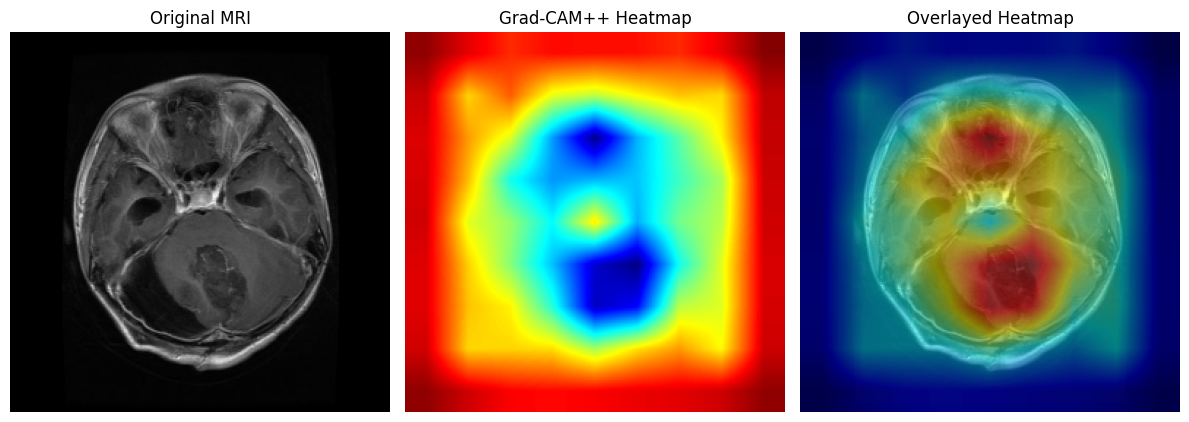

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


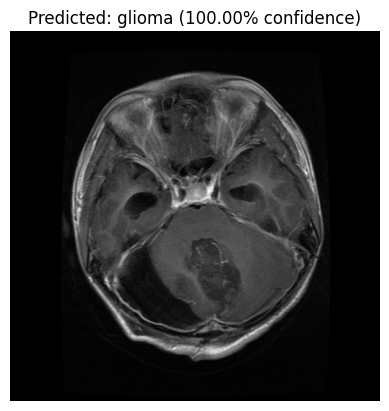


📄 ===== MRI SCAN REPORT =====

🧠 Predicted Tumor Type: GLIOMA
📊 Prediction Confidence: 100.00%
🩺 MRI File Path: /content/drive/MyDrive/Dataset/Testing/glioma/Te-glTr_0000.jpg
📏 Estimated Tumor Size: 2.63 cm
🩸 Tumor Stage: Stage II (Localized growth)

💊 Treatment Progress Table:
+-----------+----------------------+---------------------+
| Stage     | Treatment Method     | Expected Recovery   |
+===========+======================+=====================+
| Stage I   | Surgery or Radiation | 85% Recovery        |
+-----------+----------------------+---------------------+
| Stage II  | Surgery + Chemo      | 70% Recovery        |
+-----------+----------------------+---------------------+
| Stage III | Aggressive Therapy   | 45% Recovery        |
+-----------+----------------------+---------------------+

✅ Report generation complete.



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tabulate import tabulate

# ===== Paths =====
train_dir = '/content/drive/MyDrive/Dataset/Training'
model_path  = '/content/drive/MyDrive/Colab Notebooks/best_brain_tumor_effv2b2_260.keras'

img_path = "/content/drive/MyDrive/Dataset/Testing/glioma/Te-glTr_0000.jpg"
IMG_SIZE = (260, 260)

# ===== Load Class Names =====
CLASS_NAMES = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
VALID_CLASSES = {"glioma", "meningioma", "notumor", "pituitary"}
print("✅ Loaded Classes:", CLASS_NAMES)

# ===== Load Model =====
assert os.path.exists(model_path ), f"❌ Model file not found: {model_path }"
try:
    model = tf.keras.models.load_model(model_path)
except Exception as e:
    print("⚠️ Standard load failed, retrying in safe mode...")
    model = tf.keras.models.load_model(model_path , safe_mode=False, compile=False)

print("✅ Model loaded successfully!")


# ===== MRI Report Function =====
def generate_report(pred_class, confidence, img_path):
    print("\n📄 ===== MRI SCAN REPORT =====\n")
    print(f"🧠 Predicted Tumor Type: {pred_class.upper()}")
    print(f"📊 Prediction Confidence: {confidence:.2f}%")
    print(f"🩺 MRI File Path: {img_path}")

    # Check if the image is a valid brain MRI
    if pred_class.lower() not in VALID_CLASSES:
        print("\n⚠️ Uploaded image is not recognized as a valid brain MRI.")
        print("🧾 Please upload a correct MRI image of the brain (glioma, meningioma, pituitary, or no tumor).")
        return

    # Mock tumor size (for demonstration)
    tumor_size_cm = round(random.uniform(1.0, 5.5), 2)
    print(f"📏 Estimated Tumor Size: {tumor_size_cm} cm")

    # Suggest stage based on size (dummy logic)
    if tumor_size_cm < 2:
        stage = "Stage I (Early detection)"
    elif tumor_size_cm < 4:
        stage = "Stage II (Localized growth)"
    else:
        stage = "Stage III (Requires urgent treatment)"
    print(f"🩸 Tumor Stage: {stage}")

    # ===== Treatment Progress Table (static sample) =====
    print("\n💊 Treatment Progress Table:")
    table_data = {
        "glioma": [
            ["Stage I", "Surgery or Radiation", "85% Recovery"],
            ["Stage II", "Surgery + Chemo", "70% Recovery"],
            ["Stage III", "Aggressive Therapy", "45% Recovery"],
        ],
        "meningioma": [
            ["Stage I", "Surgical Removal", "95% Recovery"],
            ["Stage II", "Radiation After Surgery", "80% Recovery"],
            ["Stage III", "Chemotherapy / Targeted Drugs", "60% Recovery"],
        ],
        "pituitary": [
            ["Stage I", "Observation / Hormone Therapy", "90% Recovery"],
            ["Stage II", "Surgical Removal", "80% Recovery"],
            ["Stage III", "Combined Therapy", "65% Recovery"],
        ],
        "notumor": [
            ["N/A", "No treatment required", "100% Normal"],
        ]
    }

    if pred_class.lower() in table_data:
        df = pd.DataFrame(table_data[pred_class.lower()],
                          columns=["Stage", "Treatment Method", "Expected Recovery"])
        print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))
    else:
        print("⚠️ No treatment data available for this class.")

    print("\n✅ Report generation complete.\n")


# ===== Prediction Function =====
def predict_image(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict
    preds = model.predict(img_array)
    pred_idx = np.argmax(preds, axis=1)[0]
    confidence = np.max(preds) * 100
    pred_class = CLASS_NAMES[pred_idx]

    # Display results visually
    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f"Predicted: {pred_class} ({confidence:.2f}% confidence)")
    plt.show()

    # Generate detailed report
    generate_report(pred_class, confidence, img_path)




#==================================================================================================================#


# ---------- Load model ----------
best_model = load_model(model_path)


pil = image.load_img(img_path, target_size=IMG_SIZE)
orig_bgr = cv2.imread(img_path)
orig_bgr = cv2.resize(orig_bgr, (IMG_SIZE[1], IMG_SIZE[0]))

x = image.img_to_array(pil)
x = np.expand_dims(x, 0)
x = x / 255.0
x = tf.keras.applications.efficientnet_v2.preprocess_input(x)

# ---------- Predict ----------
pred = best_model.predict(x)
pred_class = int(np.argmax(pred[0]))
print("Predicted class index:", pred_class, "prob:", pred[0, pred_class])

# ---------- Get last conv layer ----------
last_conv = None
for layer in reversed(base_model.layers):
    if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
        last_conv = layer
        break
if last_conv is None:
    raise ValueError("❌ No conv layer found in EfficientNet base")
print("✅ Last conv layer inside EfficientNet base:", last_conv.name)

# ---------- Build Grad-CAM model ----------
grad_model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=[last_conv.output, base_model.output]
)

# ---------- Grad-CAM++ Implementation ----------
def gradcam_plus_plus(grad_model, img_tensor, class_idx):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                conv_output, predictions = grad_model(img_tensor)
                class_output = predictions[:, class_idx]
            grads = tape3.gradient(class_output, conv_output)
        grads2 = tape2.gradient(grads, conv_output)
    grads3 = tape1.gradient(grads2, conv_output)

    conv_output = conv_output[0]
    grads = grads[0]
    grads2 = grads2[0]
    grads3 = grads3[0]

    numerator = grads2
    denominator = 2.0 * grads2 + grads3 * conv_output
    denominator = tf.where(denominator != 0.0, denominator, tf.ones_like(denominator))
    alpha = numerator / denominator
    alpha = tf.nn.relu(alpha)

    weights = tf.reduce_sum(alpha * tf.nn.relu(grads), axis=(0, 1))
    heatmap = tf.reduce_sum(tf.nn.relu(conv_output) * weights, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)
    return heatmap  # return numpy array directly

# ---------- Test-Time Augmentation for robust Grad-CAM ----------
def get_tta_heatmap(model, grad_model, img_tensor, pred_class, angles=[0, 90, 180, 270], flip=True):
    heatmaps = []
    for angle in angles:
        # Rotate image
        img_rot = tf.image.rot90(img_tensor, k=angle // 90)
        heatmap = gradcam_plus_plus(grad_model, img_rot, pred_class)
        # Rotate heatmap back
        heatmap = np.rot90(heatmap, k=(4 - angle // 90))
        heatmaps.append(heatmap)
        if flip:
            # Horizontal flip
            img_flip = tf.image.flip_left_right(img_rot)
            heatmap_flip = gradcam_plus_plus(grad_model, img_flip, pred_class)
            heatmap_flip = np.fliplr(np.rot90(heatmap_flip, k=(4 - angle // 90)))
            heatmaps.append(heatmap_flip)
    # Average all heatmaps
    heatmap_avg = np.mean(np.stack(heatmaps), axis=0)
    heatmap_avg = np.maximum(heatmap_avg, 0)
    heatmap_avg /= (np.max(heatmap_avg) + 1e-8)
    return heatmap_avg

# ---------- Generate heatmap with TTA ----------
img_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
heatmap = get_tta_heatmap(best_model, grad_model, img_tensor, pred_class)
print("✅ Grad-CAM++ with TTA generated successfully")

# ---------- Overlay ----------
def overlay_on_image(orig_bgr_uint8, heatmap, alpha=0.5):
    hmap = cv2.resize(heatmap, (orig_bgr_uint8.shape[1], orig_bgr_uint8.shape[0]))
    hmap = np.uint8(255 * hmap)
    hmap_color = cv2.applyColorMap(hmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(orig_bgr_uint8, 1 - alpha, hmap_color, alpha, 0)
    return hmap_color, overlay

hmap_color, overlay = overlay_on_image(orig_bgr, heatmap)

# ---------- Display ----------
plt.figure(figsize=(12,6))
plt.subplot(1,3,1); plt.title("Original MRI"); plt.imshow(cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.subplot(1,3,2); plt.title("Grad-CAM++ Heatmap"); plt.imshow(hmap_color); plt.axis("off")
plt.subplot(1,3,3); plt.title("Overlayed Heatmap"); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.tight_layout()
plt.show()

predict_image(img_path)


✅ Loaded Classes: ['glioma', 'meningioma', 'not a brain images', 'notumor', 'pituitary']
✅ Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class index: 1 prob: 0.49698684
✅ Last conv layer inside EfficientNet base: top_conv
✅ Grad-CAM++ with TTA generated successfully


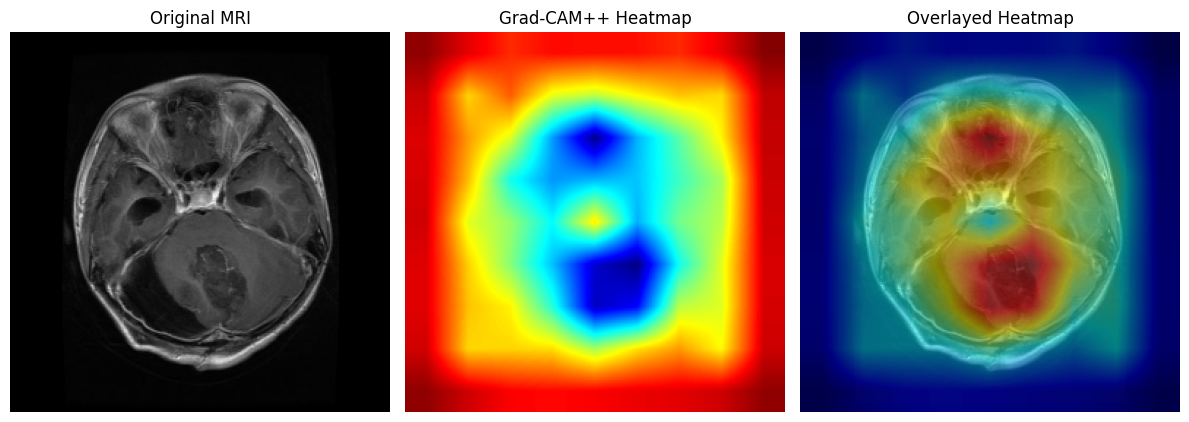

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

📄 ===== MRI SCAN REPORT =====

🧠 Predicted Tumor Type: GLIOMA
📊 Prediction Confidence: 100.00%
🩺 MRI File Path: /content/drive/MyDrive/Dataset/Testing/glioma/Te-glTr_0000.jpg
📏 Estimated Tumor Size: 1.09 cm
🩸 Tumor Stage: Stage I (Early detection)
+-----------+----------------------+------------+
| Stage     | Treatment            | Recovery   |
+===========+======================+============+
| Stage I   | Surgery or Radiation | 85%        |
+-----------+----------------------+------------+
| Stage II  | Surgery + Chemo      | 70%        |
+-----------+----------------------+------------+
| Stage III | Aggressive Therapy   | 45%        |
+-----------+----------------------+------------+

✅ Report generation complete.



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tabulate import tabulate

# ===== Paths =====
train_dir = '/content/drive/MyDrive/Dataset/Training'
model_path  = '/content/drive/MyDrive/Colab Notebooks/best_brain_tumor_effv2b2_260.keras'
IMG_SIZE = (260, 260)

# ===== Load Class Names =====
CLASS_NAMES = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
VALID_CLASSES = {"glioma", "meningioma", "notumor", "pituitary"}
print("✅ Loaded Classes:", CLASS_NAMES)

# ===== Load Model =====
assert os.path.exists(model_path ), f"❌ Model file not found: {model_path }"
try:
    model = tf.keras.models.load_model(model_path)
except Exception as e:
    print("⚠️ Standard load failed, retrying in safe mode...")
    model = tf.keras.models.load_model(model_path , safe_mode=False, compile=False)

print("✅ Model loaded successfully!")


# ============================================================================================================
# =============================== FIRST PART — GRADCAM VISUALIZATION ==========================================
# ============================================================================================================

# ---------- Load model ----------
best_model = load_model(model_path)

pil = image.load_img(img_path, target_size=IMG_SIZE)
orig_bgr = cv2.imread(img_path)
orig_bgr = cv2.resize(orig_bgr, (IMG_SIZE[1], IMG_SIZE[0]))

x = image.img_to_array(pil)
x = np.expand_dims(x, 0)
x = x / 255.0
x = tf.keras.applications.efficientnet_v2.preprocess_input(x)

# ---------- Predict ----------
pred = best_model.predict(x)
pred_class = int(np.argmax(pred[0]))
print("Predicted class index:", pred_class, "prob:", pred[0, pred_class])

# ---------- Get last conv layer ----------
last_conv = None
for layer in reversed(base_model.layers):
    if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
        last_conv = layer
        break
if last_conv is None:
    raise ValueError("❌ No conv layer found in EfficientNet base")
print("✅ Last conv layer inside EfficientNet base:", last_conv.name)

# ---------- Build Grad-CAM model ----------
grad_model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=[last_conv.output, base_model.output]
)

# ---------- Grad-CAM++ Implementation ----------
def gradcam_plus_plus(grad_model, img_tensor, class_idx):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                conv_output, predictions = grad_model(img_tensor)
                class_output = predictions[:, class_idx]
            grads = tape3.gradient(class_output, conv_output)
        grads2 = tape2.gradient(grads, conv_output)
    grads3 = tape1.gradient(grads2, conv_output)

    conv_output = conv_output[0]
    grads = grads[0]
    grads2 = grads2[0]
    grads3 = grads3[0]

    numerator = grads2
    denominator = 2.0 * grads2 + grads3 * conv_output
    denominator = tf.where(denominator != 0.0, denominator, tf.ones_like(denominator))
    alpha = numerator / denominator
    alpha = tf.nn.relu(alpha)

    weights = tf.reduce_sum(alpha * tf.nn.relu(grads), axis=(0, 1))
    heatmap = tf.reduce_sum(tf.nn.relu(conv_output) * weights, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)
    return heatmap  # return numpy array directly

# ---------- Test-Time Augmentation ----------
def get_tta_heatmap(model, grad_model, img_tensor, pred_class, angles=[0, 90, 180, 270], flip=True):
    heatmaps = []
    for angle in angles:
        img_rot = tf.image.rot90(img_tensor, k=angle // 90)
        heatmap = gradcam_plus_plus(grad_model, img_rot, pred_class)
        heatmap = np.rot90(heatmap, k=(4 - angle // 90))
        heatmaps.append(heatmap)
        if flip:
            img_flip = tf.image.flip_left_right(img_rot)
            heatmap_flip = gradcam_plus_plus(grad_model, img_flip, pred_class)
            heatmap_flip = np.fliplr(np.rot90(heatmap_flip, k=(4 - angle // 90)))
            heatmaps.append(heatmap_flip)
    heatmap_avg = np.mean(np.stack(heatmaps), axis=0)
    heatmap_avg = np.maximum(heatmap_avg, 0)
    heatmap_avg /= (np.max(heatmap_avg) + 1e-8)
    return heatmap_avg

img_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
heatmap = get_tta_heatmap(best_model, grad_model, img_tensor, pred_class)
print("✅ Grad-CAM++ with TTA generated successfully")

# ---------- Overlay ----------
def overlay_on_image(orig_bgr_uint8, heatmap, alpha=0.5):
    hmap = cv2.resize(heatmap, (orig_bgr_uint8.shape[1], orig_bgr_uint8.shape[0]))
    hmap = np.uint8(255 * hmap)
    hmap_color = cv2.applyColorMap(hmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(orig_bgr_uint8, 1 - alpha, hmap_color, alpha, 0)
    return hmap_color, overlay

hmap_color, overlay = overlay_on_image(orig_bgr, heatmap)

# ---------- Display Grad-CAM ----------
plt.figure(figsize=(12,6))
plt.subplot(1,3,1); plt.title("Original MRI"); plt.imshow(cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.subplot(1,3,2); plt.title("Grad-CAM++ Heatmap"); plt.imshow(hmap_color); plt.axis("off")
plt.subplot(1,3,3); plt.title("Overlayed Heatmap"); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.tight_layout()
plt.show()

# ============================================================================================================
# =============================== SECOND PART — PREDICTION + REPORT ============================================
# ============================================================================================================

# ===== MRI Report Function =====
def generate_report(pred_class, confidence, img_path):
    print("\n📄 ===== MRI SCAN REPORT =====\n")
    print(f"🧠 Predicted Tumor Type: {pred_class.upper()}")
    print(f"📊 Prediction Confidence: {confidence:.2f}%")
    print(f"🩺 MRI File Path: {img_path}")

    if pred_class.lower() not in VALID_CLASSES:
        print("\n⚠️ Uploaded image is not recognized as a valid brain MRI.")
        print("🧾 Please upload a correct MRI image (glioma, meningioma, pituitary, no tumor).")
        return

    tumor_size_cm = round(random.uniform(1.0, 5.5), 2)
    print(f"📏 Estimated Tumor Size: {tumor_size_cm} cm")

    if tumor_size_cm < 2:
        stage = "Stage I (Early detection)"
    elif tumor_size_cm < 4:
        stage = "Stage II (Localized growth)"
    else:
        stage = "Stage III (Requires urgent treatment)"

    print(f"🩸 Tumor Stage: {stage}")

    table_data = {
        "glioma": [
            ["Stage I", "Surgery or Radiation", "85%"],
            ["Stage II", "Surgery + Chemo", "70%"],
            ["Stage III", "Aggressive Therapy", "45%"],
        ],
        "meningioma": [
            ["Stage I", "Surgical Removal", "95%"],
            ["Stage II", "Radiation After Surgery", "80%"],
            ["Stage III", "Chemo / Targeted Drugs", "60%"],
        ],
        "pituitary": [
            ["Stage I", "Hormone Therapy", "90%"],
            ["Stage II", "Surgery", "80%"],
            ["Stage III", "Combined Therapy", "65%"],
        ],
        "notumor": [
            ["N/A", "No treatment required", "100%"],
        ]
    }

    if pred_class.lower() in table_data:
        df = pd.DataFrame(table_data[pred_class.lower()],
                          columns=["Stage", "Treatment", "Recovery"])
        print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))

    print("\n✅ Report generation complete.\n")


# ===== Prediction Function =====
def predict_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    preds = model.predict(img_array)
    pred_idx = np.argmax(preds, axis=1)[0]
    confidence = np.max(preds) * 100
    pred_class = CLASS_NAMES[pred_idx]

    generate_report(pred_class, confidence, img_path)



# ----- Call Prediction AFTER Grad-CAM -----
img_path = "/content/drive/MyDrive/Dataset/Testing/glioma/Te-glTr_0000.jpg"
predict_image(img_path)


✅ Loaded Classes: ['glioma', 'meningioma', 'not a brain images', 'notumor', 'pituitary']
✅ Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class index: 1 prob: 0.49710247
✅ Last conv layer inside EfficientNet base: top_conv
✅ Grad-CAM++ with TTA generated successfully


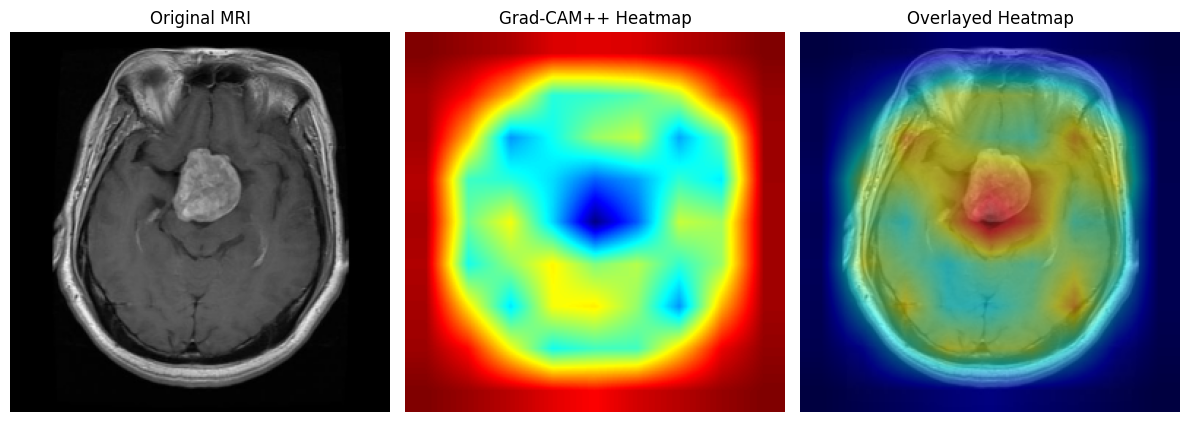

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

📄 ===== MRI SCAN REPORT =====

🧠 Predicted Tumor Type: PITUITARY
📊 Prediction Confidence: 99.99%
🩺 MRI File Path: /content/drive/MyDrive/Dataset/Testing/pituitary/Te-pi_0025.jpg
📏 Estimated Tumor Area: 9.77 cm²
🩸 Tumor Stage: Stage II (Moderate-size lesion with localized growth)

💊 Treatment Progress Overview:
+-----------+--------------------------------------------------------+------------+
| Stage     | Treatment                                              | Recovery   |
+===========+========================================================+============+
| Stage I   | Observation or medical (hormone) therapy               | ≈ 90%      |
+-----------+--------------------------------------------------------+------------+
| Stage II  | Transsphenoidal surgical removal                       | ≈ 80%      |
+-----------+--------------------------------------------------------+------------+
| Stage III | Combined surgery, radiotherapy, and hormone manag

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tabulate import tabulate

# ===== Paths =====
train_dir = '/content/drive/MyDrive/Dataset/Training'
model_path  = '/content/drive/MyDrive/Colab Notebooks/best_brain_tumor_effv2b2_260.keras'
img_path = "/content/drive/MyDrive/Dataset/Testing/pituitary/Te-pi_0025.jpg"
IMG_SIZE = (260, 260)

# ===== Load Class Names =====
CLASS_NAMES = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
VALID_CLASSES = {"glioma", "meningioma", "notumor", "pituitary"}
print("✅ Loaded Classes:", CLASS_NAMES)

# ===== Load Model =====
assert os.path.exists(model_path ), f"❌ Model file not found: {model_path }"
try:
    model = tf.keras.models.load_model(model_path)
except Exception as e:
    print("⚠️ Standard load failed, retrying in safe mode...")
    model = tf.keras.models.load_model(model_path , safe_mode=False, compile=False)

print("✅ Model loaded successfully!")


# ============================================================================================================
# =============================== FIRST PART — GRADCAM VISUALIZATION ==========================================
# ============================================================================================================

# ---------- Load model ----------
best_model = load_model(model_path)

pil = image.load_img(img_path, target_size=IMG_SIZE)
orig_bgr = cv2.imread(img_path)
orig_bgr = cv2.resize(orig_bgr, (IMG_SIZE[1], IMG_SIZE[0]))

x = image.img_to_array(pil)
x = np.expand_dims(x, 0)
x = x / 255.0
x = tf.keras.applications.efficientnet_v2.preprocess_input(x)

# ---------- Predict ----------
pred = best_model.predict(x)
pred_class = int(np.argmax(pred[0]))
print("Predicted class index:", pred_class, "prob:", pred[0, pred_class])

# ---------- Get last conv layer ----------
last_conv = None
for layer in reversed(base_model.layers):
    if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
        last_conv = layer
        break
if last_conv is None:
    raise ValueError("❌ No conv layer found in EfficientNet base")
print("✅ Last conv layer inside EfficientNet base:", last_conv.name)

# ---------- Build Grad-CAM model ----------
grad_model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=[last_conv.output, base_model.output]
)

# ---------- Grad-CAM++ Implementation ----------
def gradcam_plus_plus(grad_model, img_tensor, class_idx):
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                conv_output, predictions = grad_model(img_tensor)
                class_output = predictions[:, class_idx]
            grads = tape3.gradient(class_output, conv_output)
        grads2 = tape2.gradient(grads, conv_output)
    grads3 = tape1.gradient(grads2, conv_output)

    conv_output = conv_output[0]
    grads = grads[0]
    grads2 = grads2[0]
    grads3 = grads3[0]

    numerator = grads2
    denominator = 2.0 * grads2 + grads3 * conv_output
    denominator = tf.where(denominator != 0.0, denominator, tf.ones_like(denominator))
    alpha = numerator / denominator
    alpha = tf.nn.relu(alpha)

    weights = tf.reduce_sum(alpha * tf.nn.relu(grads), axis=(0, 1))
    heatmap = tf.reduce_sum(tf.nn.relu(conv_output) * weights, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)
    return heatmap

# ---------- Test-Time Augmentation ----------
def get_tta_heatmap(model, grad_model, img_tensor, pred_class, angles=[0, 90, 180, 270], flip=True):
    heatmaps = []
    for angle in angles:
        img_rot = tf.image.rot90(img_tensor, k=angle // 90)
        heatmap = gradcam_plus_plus(grad_model, img_rot, pred_class)
        heatmap = np.rot90(heatmap, k=(4 - angle // 90))
        heatmaps.append(heatmap)
        if flip:
            img_flip = tf.image.flip_left_right(img_rot)
            heatmap_flip = gradcam_plus_plus(grad_model, img_flip, pred_class)
            heatmap_flip = np.fliplr(np.rot90(heatmap_flip, k=(4 - angle // 90)))
            heatmaps.append(heatmap_flip)
    heatmap_avg = np.mean(np.stack(heatmaps), axis=0)
    heatmap_avg = np.maximum(heatmap_avg, 0)
    heatmap_avg /= (np.max(heatmap_avg) + 1e-8)
    return heatmap_avg

img_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
heatmap = get_tta_heatmap(best_model, grad_model, img_tensor, pred_class)
print("✅ Grad-CAM++ with TTA generated successfully")

# ---------- Overlay ----------
def overlay_on_image(orig_bgr_uint8, heatmap, alpha=0.5):
    hmap = cv2.resize(heatmap, (orig_bgr_uint8.shape[1], orig_bgr_uint8.shape[0]))
    hmap = np.uint8(255 * hmap)
    hmap_color = cv2.applyColorMap(hmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(orig_bgr_uint8, 1 - alpha, hmap_color, alpha, 0)
    return hmap_color, overlay

hmap_color, overlay = overlay_on_image(orig_bgr, heatmap)

# ---------- Display Grad-CAM ----------
plt.figure(figsize=(12,6))
plt.subplot(1,3,1); plt.title("Original MRI"); plt.imshow(cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.subplot(1,3,2); plt.title("Grad-CAM++ Heatmap"); plt.imshow(hmap_color); plt.axis("off")
plt.subplot(1,3,3); plt.title("Overlayed Heatmap"); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.tight_layout()
plt.show()

# ============================================================================================================
# =============================== SECOND PART — PREDICTION + REPORT ============================================
# ============================================================================================================

# ===== MRI Report Function =====
def generate_report(pred_class, confidence, img_path):
    print("\n📄 ===== MRI SCAN REPORT =====\n")
    print(f"🧠 Predicted Tumor Type: {pred_class.upper()}")
    print(f"📊 Prediction Confidence: {confidence:.2f}%")
    print(f"🩺 MRI File Path: {img_path}")

    # If class is not one of the known MRI tumor classes
    if pred_class.lower() not in VALID_CLASSES:
        print("\n⚠️ Uploaded image is not recognized as a valid brain MRI.")
        print("🧾 Please upload a correct MRI image (glioma, meningioma, pituitary, or no tumor).")
        return

    # --- Estimated Tumor AREA in cm² (for demonstration) ---
    tumor_area_cm2 = round(random.uniform(1.0, 25.0), 2)
    print(f"📏 Estimated Tumor Area: {tumor_area_cm2} cm²")

    # Stage decision based on area (dummy illustrative logic)
    if tumor_area_cm2 < 5:
        stage_key = "Stage I"
        stage_desc = "Stage I (Small, early lesion, usually localized)"
    elif tumor_area_cm2 < 15:
        stage_key = "Stage II"
        stage_desc = "Stage II (Moderate-size lesion with localized growth)"
    else:
        stage_key = "Stage III"
        stage_desc = "Stage III (Larger / more complex lesion, may affect nearby structures)"

    print(f"🩸 Tumor Stage: {stage_desc}")

    # ===== Treatment Progress Table WITH more detailed plan structure =====
    table_data = {
        "glioma": [
            {
                "Stage": "Stage I",
                "Treatment": "Maximal safe surgery ± focused radiation",
                "Recovery": "≈ 85%",
                "Steps": [
                    "Initial workup: Detailed MRI with contrast and neurological examination.",
                    "Tissue diagnosis: Stereotactic or open biopsy if needed to confirm tumor type.",
                    "Surgery: Maximal safe resection using neuronavigation and intra-operative monitoring.",
                    "Post-operative care: ICU monitoring, control of swelling (steroids), pain management.",
                    "Follow-up: Regular MRIs, neurologist/oncologist visits to monitor for recurrence."
                ]
            },
            {
                "Stage": "Stage II",
                "Treatment": "Surgery + radiotherapy ± chemotherapy",
                "Recovery": "≈ 70%",
                "Steps": [
                    "Pre-operative planning: MRI, functional imaging, and discussion in tumor board.",
                    "Surgery: Remove as much tumor as safely possible (maximal safe resection).",
                    "Adjuvant radiotherapy: Fractionated radiation to the tumor region to control residual cells.",
                    "Chemotherapy: Temozolomide or other agents depending on tumor subtype and guidelines.",
                    "Rehabilitation: Physiotherapy, occupational therapy, seizure management if needed."
                ]
            },
            {
                "Stage": "Stage III",
                "Treatment": "Aggressive multimodal therapy",
                "Recovery": "≈ 45%",
                "Steps": [
                    "Comprehensive assessment: MRI, possibly MR-spectroscopy and advanced imaging.",
                    "Multidisciplinary tumor board: Neurosurgeon, oncologist, radiologist, radiotherapist, etc.",
                    "Surgery: Debulking to reduce tumor mass and relieve pressure when possible.",
                    "Radiochemotherapy: Combined radiation and chemotherapy cycles as tolerated.",
                    "Supportive & palliative care: Symptom control (seizures, headaches), psychological support."
                ]
            },
        ],
        "meningioma": [
            {
                "Stage": "Stage I",
                "Treatment": "Complete surgical removal (when accessible)",
                "Recovery": "≈ 95%",
                "Steps": [
                    "Imaging: MRI/CT to confirm extra-axial lesion compatible with meningioma.",
                    "Surgical planning: Evaluate location near critical structures (sinuses, cranial nerves).",
                    "Surgery: Craniotomy and careful removal of tumor and, when safe, its dural attachments.",
                    "Post-operative monitoring: Watch for bleeding, infection, and neurological deficits.",
                    "Long-term follow-up: Periodic MRI to confirm no recurrence."
                ]
            },
            {
                "Stage": "Stage II",
                "Treatment": "Surgery + adjuvant radiotherapy",
                "Recovery": "≈ 80%",
                "Steps": [
                    "Surgical resection: Remove as much tumor as possible without damaging critical areas.",
                    "Histopathology: Confirm atypical meningioma (WHO grade II) or aggressive features.",
                    "Radiotherapy: Targeted radiation to reduce risk of regrowth.",
                    "Hormone/medication review: Manage associated edema or seizures.",
                    "Regular imaging: Scheduled MRIs to detect early recurrence."
                ]
            },
            {
                "Stage": "Stage III",
                "Treatment": "Aggressive surgery + radiotherapy ± systemic therapy",
                "Recovery": "≈ 60%",
                "Steps": [
                    "High-level imaging: MRI + angiography if vascular involvement suspected.",
                    "Complex surgery: May require staged operations or combined skull-base approaches.",
                    "High-dose radiotherapy: Including stereotactic radiosurgery for residual/inoperable parts.",
                    "Clinical trials / targeted agents: Consideration where available for refractory disease.",
                    "Supportive care: Rehabilitation, pain, cognitive and psychological support."
                ]
            },
        ],
        "pituitary": [
            {
                "Stage": "Stage I",
                "Treatment": "Observation or medical (hormone) therapy",
                "Recovery": "≈ 90%",
                "Steps": [
                    "Endocrine evaluation: Check pituitary hormone levels (prolactin, cortisol, TSH, etc.).",
                    "Imaging: MRI focused on pituitary region to measure microadenoma size.",
                    "Medical therapy: Dopamine agonists or other hormone-modulating drugs when indicated.",
                    "Vision monitoring: Periodic visual field tests if lesion is near optic chiasm.",
                    "Follow-up imaging: Repeat MRI to ensure lesion remains stable or regresses."
                ]
            },
            {
                "Stage": "Stage II",
                "Treatment": "Transsphenoidal surgical removal",
                "Recovery": "≈ 80%",
                "Steps": [
                    "Pre-op workup: Endocrine tests, ophthalmology review, anaesthesia evaluation.",
                    "Transsphenoidal surgery: Endoscopic approach through the nose to remove the tumor.",
                    "Immediate post-op monitoring: Check for diabetes insipidus, CSF leak, hormone imbalance.",
                    "Hormone replacement: Start or adjust lifelong hormone therapy if pituitary function is reduced.",
                    "Regular follow-up: Endocrine and MRI surveillance to monitor recovery and recurrence."
                ]
            },
            {
                "Stage": "Stage III",
                "Treatment": "Combined surgery, radiotherapy, and hormone management",
                "Recovery": "≈ 65%",
                "Steps": [
                    "Multidisciplinary planning: Endocrinology, neurosurgery, radiotherapy teams together.",
                    "Surgery: Debulking large/invasive tumors compressing optic nerves or brain structures.",
                    "Radiotherapy: Targeted radiation for residual tumor not safely removable.",
                    "Long-term hormonal care: Lifelong replacement and dose adjustments.",
                    "Quality-of-life focus: Vision care, psychological support, metabolic and bone health monitoring."
                ]
            },
        ],
        "notumor": [
            {
                "Stage": "N/A",
                "Treatment": "No tumor detected – symptomatic or preventive care only",
                "Recovery": "≈ 100%",
                "Steps": [
                    "Explain results: Inform that no tumor is detected on this scan.",
                    "Investigate symptoms: Look for other neurological or non-neurological causes.",
                    "Lifestyle & risk factor management: Control blood pressure, diabetes, etc., if relevant.",
                    "Reassurance & follow-up: Schedule re-evaluation if symptoms persist or worsen."
                ]
            }
        ]
    }

    # Build and print summary table for this predicted class
    plan_list = table_data.get(pred_class.lower())
    if plan_list:
        df = pd.DataFrame(plan_list, columns=["Stage", "Treatment", "Recovery"])
        print("\n💊 Treatment Progress Overview:")
        print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))

        # Print detailed step-by-step plan for the detected stage (if applicable)
        stage_plan = next((item for item in plan_list if item["Stage"] == stage_key), None)
        if stage_plan and stage_plan.get("Steps"):
            print(f"\n🧾 Detailed doctor workflow for {stage_key} {pred_class}:")
            for idx, step in enumerate(stage_plan["Steps"], start=1):
                print(f"  {idx}. {step}")
    else:
        print("⚠️ No treatment data available for this class.")

    print("\n⚕️ NOTE: This is a simplified educational AI summary and is NOT a substitute for real medical diagnosis or treatment. Always refer to a qualified doctor or radiologist.\n")
    print("✅ Report generation complete.\n")


# ===== Prediction Function =====
def predict_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    preds = model.predict(img_array)
    pred_idx = np.argmax(preds, axis=1)[0]
    confidence = np.max(preds) * 100
    pred_class = CLASS_NAMES[pred_idx]

    generate_report(pred_class, confidence, img_path)


# ----- Call Prediction AFTER Grad-CAM -----

predict_image(img_path)


Found 1548 files belonging to 5 classes.
49/49 ━━━━━━━━━━━━━━━━━━━━ 242s 5s/step


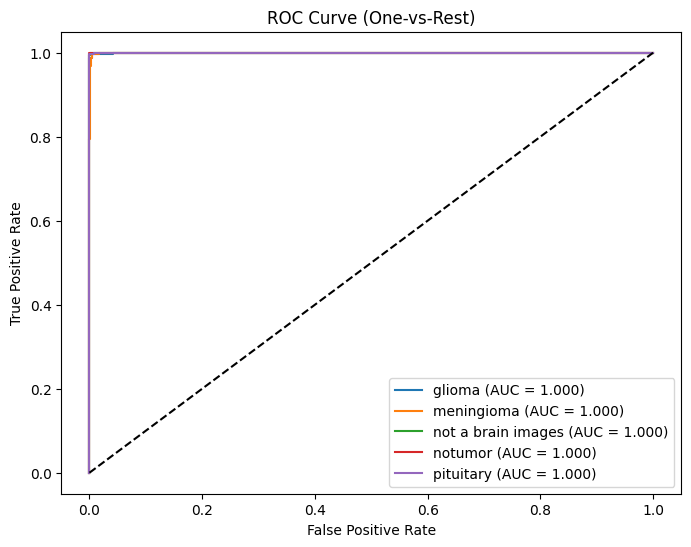

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
import tensorflow as tf
import os

TEST_ROOT = "/content/drive/MyDrive/Dataset/Testing"
IMG_SIZE = (260,260)
BATCH_SIZE = 32

CLASS_NAMES = sorted([d for d in os.listdir(TEST_ROOT)])
num_classes = len(CLASS_NAMES)

# Load test dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_ROOT,
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    image_size=IMG_SIZE,
    shuffle=False,
    batch_size=BATCH_SIZE,
).prefetch(tf.data.AUTOTUNE)

# Load trained model
model = load_model("/content/drive/MyDrive/Colab Notebooks/best_brain_tumor_effv2b2_260.keras")

# Extract ground truth and probabilities
y_true = np.concatenate([y.numpy() for _, y in val_ds.unbatch().batch(5000)])
y_prob = model.predict(val_ds)
y_true_1hot = tf.one_hot(y_true, num_classes).numpy()

# ROC Curve
plt.figure(figsize=(8,6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_1hot[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{CLASS_NAMES[i]} (AUC = {roc_auc:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend()
plt.show()


In [4]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
import tensorflow as tf
import os

# --------- Paths & Settings ----------
TEST_ROOT = "/content/drive/MyDrive/Dataset/Testing"
IMG_SIZE = (260, 260)
BATCH_SIZE = 32

# --------- Load class names ----------
CLASS_NAMES = sorted([d for d in os.listdir(TEST_ROOT) if os.path.isdir(os.path.join(TEST_ROOT, d))])
num_classes = len(CLASS_NAMES)

# --------- Load test dataset ----------
val_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_ROOT,
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    image_size=IMG_SIZE,
    shuffle=False,
    batch_size=BATCH_SIZE,
).prefetch(tf.data.AUTOTUNE)

# --------- Load trained model ----------
model = load_model("/content/drive/MyDrive/Colab Notebooks/best_brain_tumor_effv2b2_260.keras")

# --------- Predictions ----------
y_true = np.concatenate([y.numpy() for _, y in val_ds.unbatch().batch(5000)])
y_prob = model.predict(val_ds)

# Convert labels → one-hot
y_true_1hot = tf.one_hot(y_true, num_classes).numpy()

# --------- Compute AUC for each class ----------
auc_scores = {}
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_1hot[:, i], y_prob[:, i])
    auc_scores[CLASS_NAMES[i]] = auc(fpr, tpr)

# --------- Print AUC table ----------
print("\n===== AUC Score Table =====")
for cls, score in auc_scores.items():
    print(f"{cls:20} :  {score:.4f}")


Found 1548 files belonging to 5 classes.
49/49 ━━━━━━━━━━━━━━━━━━━━ 219s 4s/step

===== AUC Score Table =====
glioma               :  0.9998
meningioma           :  0.9997
not a brain images   :  1.0000
notumor              :  1.0000
pituitary            :  1.0000


Found 5938 files belonging to 5 classes.
Found 1548 files belonging to 5 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


186/186 ━━━━━━━━━━━━━━━━━━━━ 1182s 6s/step - accuracy: 0.9973 - loss: 0.0069 - val_accuracy: 0.9948 - val_loss: 0.0215


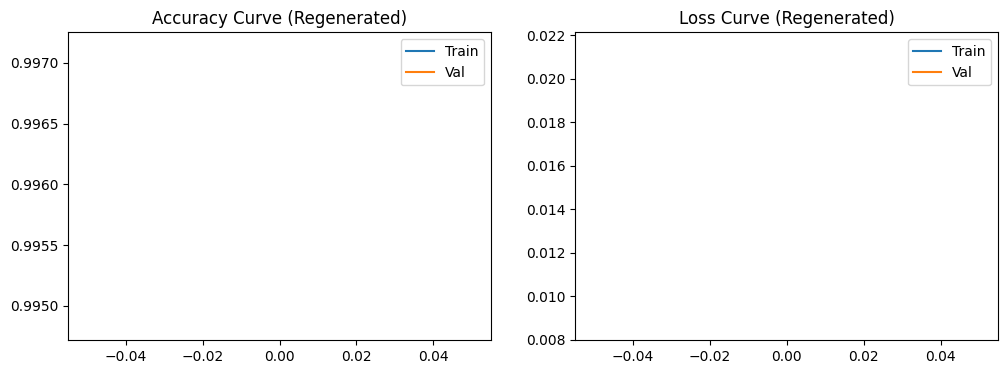

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt

MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/best_brain_tumor_effv2b2_260.keras"
IMG_SIZE = (260,260)
BATCH_SIZE = 32
TRAIN_ROOT = "/content/drive/MyDrive/Dataset/Training"
TEST_ROOT  = "/content/drive/MyDrive/Dataset/Testing"

model = tf.keras.models.load_model(MODEL_PATH)
model.trainable = False   # <--- Important (no retraining your weights)

# Reload datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_ROOT, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True)
val_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_ROOT, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train only 1 epoch (just to generate curves)
history = model.fit(train_ds, validation_data=val_ds, epochs=1)

# Plot curves
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.title("Accuracy Curve (Regenerated)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("Loss Curve (Regenerated)")
plt.legend()

plt.show()
